In [ ]:
pip install pandas numpy faker pyarrow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.9 MB/s eta 0:00:00


In [ ]:
%pip install faker

In [ ]:
import pandas as pd
import numpy as np
from faker import Faker
import random

# Activating the Faker library
fake = Faker()

# Download data from Kaggle (after downloading the file manually or via the Kaggle API)
df = pd.read_csv("cardio_train.csv", sep=';')

# Change column names to be clear
df.rename(columns={
    'age': 'age_days',
    'ap_hi': 'systolic_bp',
    'ap_lo': 'diastolic_bp',
    'cholesterol': 'cholesterol_level',
    'gluc': 'glucose_level',
    'cardio': 'heart_disease'
}, inplace=True)

# Converting age from days to years
df['age'] = (df['age_days'] / 365).astype(int)
df.drop(columns=['age_days'], inplace=True)

# Function for creating (generating) synthetic row
def generate_synthetic_row():
    return {
        'age': random.randint(29, 80),
        'gender': random.choice([1, 2]),  # 1: نساء، 2: رجال
        'height': random.randint(140, 200),
        'weight': round(random.uniform(45, 120), 1),
        'systolic_bp': random.randint(90, 180),
        'diastolic_bp': random.randint(60, 120),
        'cholesterol_level': random.randint(1, 3),
        'glucose_level': random.randint(1, 3),
        'smoke': random.randint(0, 1),
        'alco': random.randint(0, 1),
        'active': random.randint(0, 1),
        'heart_disease': random.randint(0, 1)
    }

# Number of records to be generated
target_size = 1_000_000
current_size = df.shape[0]
needed_rows = target_size - current_size

synthetic_data = [generate_synthetic_row() for _ in range(needed_rows)]
df_synth = pd.DataFrame(synthetic_data)

# Integrating real data with synthetic_data
df_big = pd.concat([df, df_synth], ignore_index=True)

# Save results
df_big.to_csv("bigdata_heart.csv", index=False)
df_big.to_parquet("bigdata_heart.parquet", index=False)

print(f"A dataset with {df_big.shape[0]} records has been created.")


A dataset with 1000000 records has been created.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 70000 non-null  int64  
 1   gender             70000 non-null  int64  
 2   height             70000 non-null  int64  
 3   weight             70000 non-null  float64
 4   systolic_bp        70000 non-null  int64  
 5   diastolic_bp       70000 non-null  int64  
 6   cholesterol_level  70000 non-null  int64  
 7   glucose_level      70000 non-null  int64  
 8   smoke              70000 non-null  int64  
 9   alco               70000 non-null  int64  
 10  active             70000 non-null  int64  
 11  heart_disease      70000 non-null  int64  
 12  age                70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [ ]:
df_big.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   id                 70000 non-null    float64
 1   gender             1000000 non-null  int64  
 2   height             1000000 non-null  int64  
 3   weight             1000000 non-null  float64
 4   systolic_bp        1000000 non-null  int64  
 5   diastolic_bp       1000000 non-null  int64  
 6   cholesterol_level  1000000 non-null  int64  
 7   glucose_level      1000000 non-null  int64  
 8   smoke              1000000 non-null  int64  
 9   alco               1000000 non-null  int64  
 10  active             1000000 non-null  int64  
 11  heart_disease      1000000 non-null  int64  
 12  age                1000000 non-null  int64  
dtypes: float64(2), int64(11)
memory usage: 99.2 MB


In [ ]:
!pip install pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Creating a Spark session
spark = SparkSession.builder \
    .appName("Heart Disease Big Data Analysis") \
    .getOrCreate()

# Reading a Parquet file (faster than CSV)
df = spark.read.parquet("bigdata_heart.parquet")

# Display 5 records to confirm reading
df.show(5)

# Display the column schema
df.printSchema()

# Check the number of records
print(f"Number of records: {df.count()}")
# Cleaning up illogical or outliers
df_clean = df.filter(
    (col("systolic_bp") > 50) & (col("systolic_bp") < 250) &
    (col("diastolic_bp") > 30) & (col("diastolic_bp") < 200) &
    (col("height") > 100) & (col("height") < 250) &
    (col("weight") > 30) & (col("weight") < 250)
)

# Save the clean copy
df_clean.write.mode("overwrite").parquet("bigdata_heart_clean.parquet")

print(f"Number of records after cleaning: {df_clean.count()}")

spark.stop()


+---+------+------+------+-----------+------------+-----------------+-------------+-----+----+------+-------------+---+
| id|gender|height|weight|systolic_bp|diastolic_bp|cholesterol_level|glucose_level|smoke|alco|active|heart_disease|age|
+---+------+------+------+-----------+------------+-----------------+-------------+-----+----+------+-------------+---+
|0.0|     2|   168|  62.0|        110|          80|                1|            1|    0|   0|     1|            0| 50|
|1.0|     1|   156|  85.0|        140|          90|                3|            1|    0|   0|     1|            1| 55|
|2.0|     1|   165|  64.0|        130|          70|                3|            1|    0|   0|     0|            1| 51|
|3.0|     2|   169|  82.0|        150|         100|                1|            1|    0|   0|     1|            1| 48|
|4.0|     1|   156|  56.0|        100|          60|                1|            1|    0|   0|     0|            0| 47|
+---+------+------+------+-----------+--

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import time

# Creating a Spark session
spark = SparkSession.builder \
    .appName("Heart Disease Prediction with Spark MLlib") \
    .getOrCreate()

# Reading clean data
df = spark.read.parquet("bigdata_heart_clean.parquet")

# Data processing
feature_cols = ['age', 'gender', 'height', 'weight', 'systolic_bp',
                'diastolic_bp', 'cholesterol_level', 'glucose_level',
                'smoke', 'alco', 'active']

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_ml = assembler.transform(df)

#Ensure that the classification column is numeric.
label_indexer = StringIndexer(inputCol="heart_disease", outputCol="label")
df_ml = label_indexer.fit(df_ml).transform(df_ml)

# Splitting data for train and test
train_data, test_data = df_ml.randomSplit([0.8, 0.2], seed=42)

# Function for train and evaluate any model
def train_and_evaluate(model, model_name):
    start_time = time.time()
    model_fit = model.fit(train_data)
    predictions = model_fit.transform(test_data)
    elapsed_time = time.time() - start_time

    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)

    print(f"{model_name} - Accuracy: {accuracy:.4f} - Time: {elapsed_time:.2f} sec")
    return model_name, accuracy, elapsed_time

# Logistic Regression Experiment
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10)
lr_result = train_and_evaluate(lr, "Logistic Regression")

# Random Forest Experiment
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=50)
rf_result = train_and_evaluate(rf, "Random Forest")

# Gradient-Boosted Trees Experiment
gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=20)
gbt_result = train_and_evaluate(gbt, "Gradient-Boosted Trees")

# عرض مقارنة النتائج
results = [lr_result, rf_result, gbt_result]
print("\n=== Model Comparison ===")
for name, acc, time_taken in results:
    print(f"{name}: Accuracy={acc:.4f}, Time={time_taken:.2f} sec")

spark.stop()


Logistic Regression - Accuracy: 0.5095 - Time: 35.53 sec
Random Forest - Accuracy: 0.5164 - Time: 87.23 sec
Gradient-Boosted Trees - Accuracy: 0.5156 - Time: 92.72 sec

=== Model Comparison ===
Logistic Regression: Accuracy=0.5095, Time=35.53 sec
Random Forest: Accuracy=0.5164, Time=87.23 sec
Gradient-Boosted Trees: Accuracy=0.5156, Time=92.72 sec


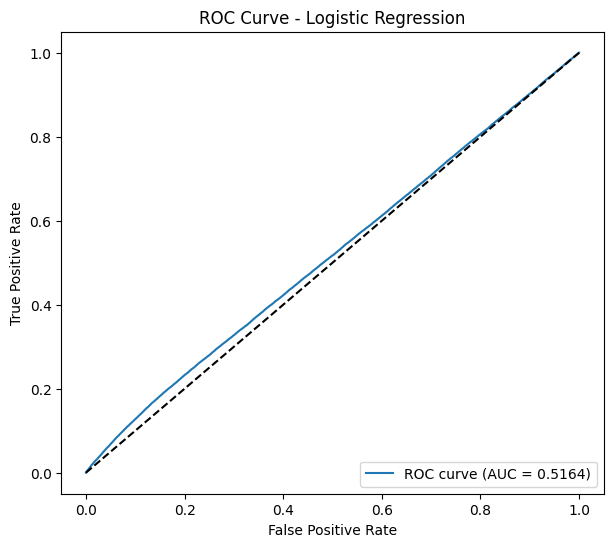

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract ROC curve points
roc = predictions.select("label", "probability").toPandas()
roc["prob_1"] = roc["probability"].apply(lambda x: float(x[1]))

from sklearn.metrics import roc_curve, auc as sk_auc

fpr, tpr, thresholds = roc_curve(roc["label"], roc["prob_1"])
roc_auc = sk_auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.show()
